## Analysis of single trial in empty arena

### Import ctrax tracking data

In [1]:
from scipy.io import loadmat
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
import matplotlib.colors as colors
from os import listdir, mkdir

import seaborn as sns
sns.set_style('ticks')

from sys import path
from os.path import isfile, sep
from glob import glob

path.insert(0, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import *
from velocityDistributionPlots import *

%matplotlib inline

In [55]:
arena = 'empty'
baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FreeWalkingArena/1_ObjectTracking/Data/old/emptyArena/mWTB/m03/'

flyID = baseDir.split(sep)[-3][1:] + baseDir.split(sep)[-2]

matfiles = [filepath.split(sep)[-1] for filepath in glob(baseDir + '*.mat')]
matfiles = sorted(matfiles)
datNameTrunk = matfiles[0][:-5]

infile = [datNameTrunk + str(x) + '.mat' for x in range(0,4)]

titleString = ''.join(['fly',flyID,'in',arena,'arena'])

In [56]:
def loadCtraxData(indat):
    #data columns to be extracted from ctrax file
    keyList = ['timestamps','x_pos','y_pos','ntargets','identity','angle']
    
    dat = [indat[k] for k in keyList]
    
    # Reorganise fly position arrays into numpy arrays
    numFrames = len(dat[0])
    time = np.zeros(numFrames)
    xPos = np.zeros(numFrames)
    yPos = np.zeros(numFrames)
    angle = np.zeros(numFrames)

    pointer = 0
    for t in range(numFrames):
        numFlies = dat[3][t].astype('int')[0]
        
        if not numFlies == 1:
            time[t] = dat[0][t]
            xPos[t] = np.nan
            yPos[t] = np.nan
            angle[t] = np.nan
                        
        else: # everything is okay
            time[t] = dat[0][t]
            xPos[t] = dat[1][pointer]
            yPos[t] = dat[2][pointer]
            angle[t] = dat[5][pointer]
            
        pointer += numFlies

    return time, xPos, yPos, angle

In [57]:
time = []
xPos = []
yPos = []
angle = []

for f in range(0,4):
    #load matlab data and convert
    indat = loadmat(baseDir + infile[f])
    
    timePiece, xPosPiece, yPosPiece, anglePiece = loadCtraxData(indat)
    
    time = np.hstack((time,timePiece))
    xPos = np.hstack((xPos,xPosPiece))
    yPos = np.hstack((yPos,yPosPiece))
    angle = np.hstack((angle,anglePiece))

###### Conversion to metric units, adjustment of time stamps

In [58]:
pixel2mm = 0.471; # pixel2mm (480px, 226mm arena) and 20Hz video sampling
videoSF = 20

In [59]:
xPos = xPos*pixel2mm

#flip y axis (artifact from image processing)
yPos = np.abs(yPos-480)*pixel2mm 
#transform orientation angle to account for flipped y-axis
angle = np.mod((2*np.pi - angle),2*np.pi)

12000
12000


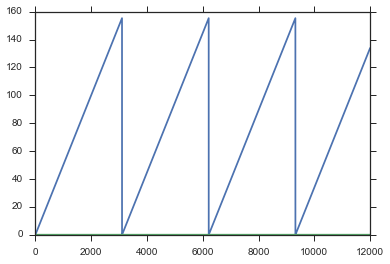

In [60]:
#unwrap time
plt.plot(time)
jumps = np.where(np.diff(time)<0)
timeSec = []
timeSec = time[0:jumps[0][0]+1]
cumJump = 0
for index,jump in enumerate(jumps[0]):
    cumJump = cumJump + time[jump] + np.diff(time[jump-2:jump])
    
    if(index<2): jumpTo = jumps[0][index+1]+1
    else: jumpTo = -1
    timeSec = np.hstack((timeSec,time[jump+1:jumpTo]+cumJump[0]))

timeSec = np.hstack((timeSec,time[-1]+cumJump[0]))
print(len(time))
print(len(timeSec))

plt.plot(np.diff(timeSec));

In [61]:
#TODO Change!

#with open(baseDir + flyID +'_' + arena + '_raw.csv', 'wb') as csvfile:
#    matwriter = csv.writer(csvfile) # delimiter=' ', quotechar='\n', quoting=csv.QUOTE_MINIMAL)
#    matwriter.writerows(datCombi)
#    
#np.save(baseDir + flyID +'_' + arena + '_raw', datCombi)

### Basic processing of tracking data

#### Trace

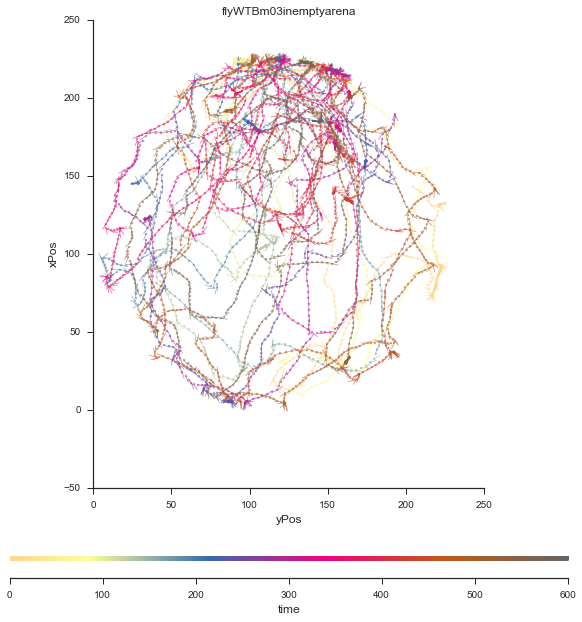

In [62]:
frameStart = 0
frameEnd = len(xPos)
frameStep = 2
frameRange = range(frameStart,frameEnd,frameStep)
colMap = 'Accent' #'nipy_spectral'

trajfig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2,1,height_ratios=np.hstack((12,1)))
sns.set_style('ticks')

axTraj = trajfig.add_subplot(gs[0]) #trace plot
axTime = trajfig.add_subplot(gs[1]) #time line
plotPosInRange(axTraj,axTime,frameRange,timeSec,xPos,yPos,angle,colMap,4,0.5,5)
axTraj.set_ylabel('xPos',fontsize=12)
axTraj.set_xlabel('yPos',fontsize=12)  
axTraj.set_title(titleString)

axTime.set_xlabel('time',fontsize=12)  
myAxisTheme(axTraj)
timeAxisTheme(axTime)

trajfig.savefig(baseDir + flyID + '_' + arena + '_tracePlot.pdf', format = 'pdf')

### Velocity distributions

In [63]:
sampleRate = np.median(1/np.diff(time))
print(sampleRate)

downSample = 1
sampleRange = range(0,len(xPos),downSample)

timeDS = time[sampleRange]
print(np.median(1/np.diff(timeDS)))

transV = np.zeros(len(timeDS))
rotV = np.zeros(len(timeDS))

transV[0:-1] = np.sqrt(np.square(np.diff(xPos[sampleRange])) + np.square(np.diff(yPos[sampleRange])) )

rotV[0:-1] = np.diff(angle[sampleRange]) 
rotV[rotV>np.pi] = rotV[rotV>np.pi]-2*np.pi
rotV[rotV<-np.pi] = rotV[rotV<-np.pi]+2*np.pi

transV[0:-1] = transV[0:-1] / np.diff(timeDS) 
rotV[0:-1] = rotV[0:-1] / np.diff(timeDS) 

transV[np.where(np.isnan(transV))[0]] = 0
rotV[np.where(np.isnan(rotV))[0]] = 0

19.9980002
19.9980002


In [64]:
N = 5
transVFilt= np.convolve(transV, np.ones((N,))/N, mode='same')
rotVFilt= np.convolve(rotV, np.ones((N,))/N, mode='same')

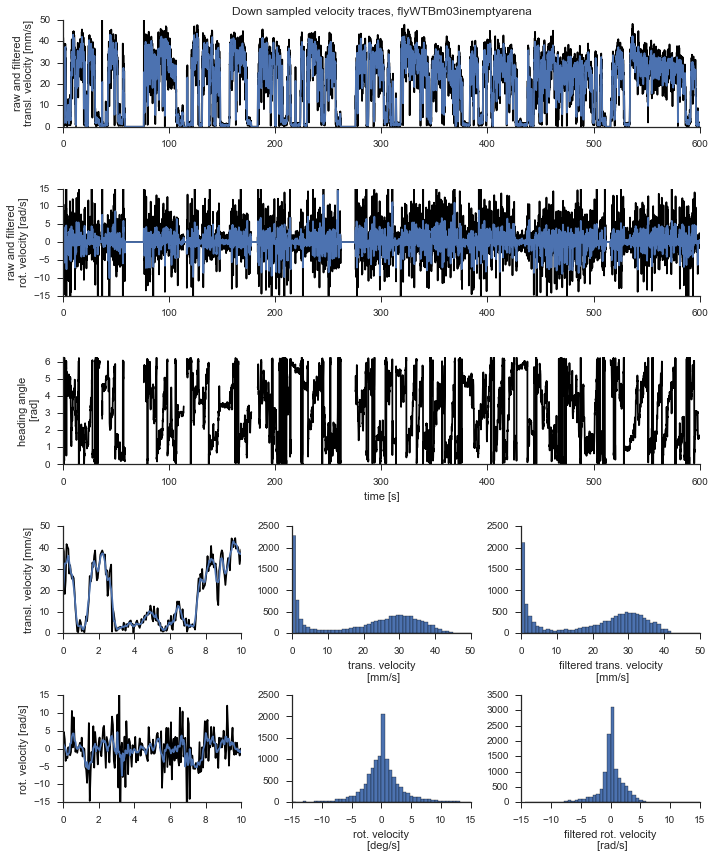

In [65]:
rotLim = (-15, 15)
transLim = (0, 50)
angleLim = (0, 2*np.pi)
summaryFig = velocitySummaryPlot(timeSec, transV, transVFilt, rotV, rotVFilt, angle, rotLim, transLim,
                                 angleLim, 'Down sampled velocity traces, ' + titleString)
summaryFig.savefig(baseDir + flyID + '_' + arena + '_veloDistributions.pdf', format = 'pdf')

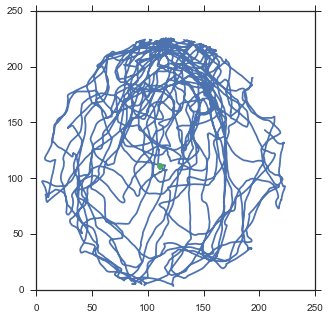

In [66]:
objectLoc = (111,111)
fig = plt.figure(figsize = (5,5))
plt.plot(xPos,yPos)
plt.plot(objectLoc[0],objectLoc[1],marker = 'o');

In [67]:
def dotProduct_2D(a,b):
    #2D dot product
    return a[0,:]*b[0,:] + a[1,:]*b[1,:]

def vecLength_2D(a):
    return np.sqrt(a[0,:]**2 + a[1,:]**2)

In [68]:
# Vector to object location
objectDirection =np.vstack((objectLoc[0]-xPos,objectLoc[1]-yPos))

objDistance = vecLength_2D(objectDirection)

# Fly orientation vector
flyDirection = np.vstack((np.cos(angle),np.sin(angle)))

Turn threshold:
4.75720806108


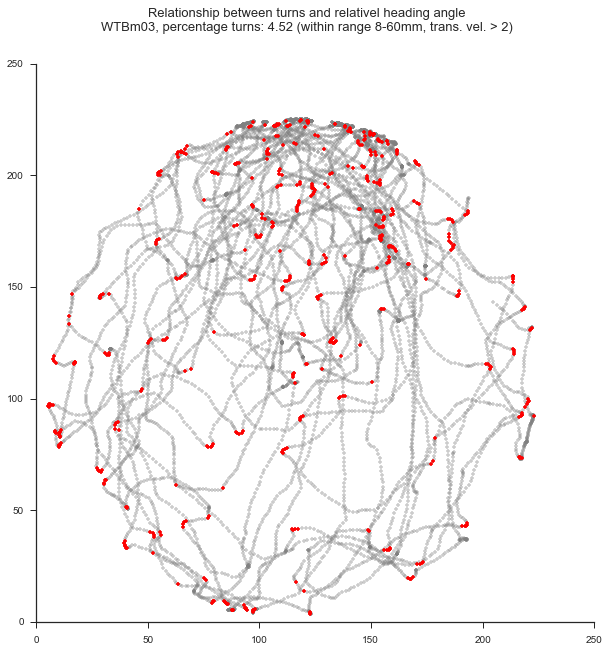

In [69]:
sf = 0
ef = len(xPos)

arenaRad = 60

near = 8
far = arenaRad
vTransTH = 2

turnTH = 3*np.std(abs(rotVFilt))
print('Turn threshold:')
print(turnTH)

turnMask = (abs(rotVFilt) > turnTH)

selectedRangeDistAll = np.logical_and(objDistance > near, objDistance < far)

selectedRangeDist = np.logical_and(np.logical_and(objDistance > near, objDistance < far), transV > vTransTH)
selectedRangeDistTurn = np.logical_and(np.logical_and(objDistance > near, objDistance < far), turnMask)


turnFig = plt.figure(figsize = (10,10))
turnFigax = turnFig.add_subplot(111)
turnFigax.plot(xPos[:],yPos[:],'.',color = 'grey',alpha = 0.4)

turnFigax.plot(xPos[turnMask],yPos[turnMask],'r.');

turnFig.suptitle('Relationship between turns and relativel heading angle\n' + flyID +
                 ', percentage turns: ' + str(round(100.0*sum(turnMask)/len(rotVFilt), 2)) +
                 ' (within range ' + str(near) + '-' + str(far) + 'mm, trans. vel. > ' + str(vTransTH) + ')\n',
                 fontsize=13)
myAxisTheme(turnFigax)
turnFig.savefig(baseDir + flyID + '_' + arena + '_turnAnnotation.pdf', format = 'pdf')

### Phase plots

In [70]:
# Angle of objectDirection rel. to x-axis
phi = np.arccos( objectDirection[0,:] / vecLength_2D(objectDirection) )
phi[objectDirection[1,:]<0] = 2*np.pi - phi[objectDirection[1,:]<0]

In [71]:
# Angle to object relative from fly's orientation
dotProd = dotProduct_2D(flyDirection,objectDirection)
lenFlyVec = np.sqrt(flyDirection[0,:]**2 + flyDirection[1,:]**2)
lenObjVec = np.sqrt(objectDirection[0,:]**2 + objectDirection[1,:]**2)

gamma = np.arccos( dotProd / (lenFlyVec * lenObjVec) )

gammaFull = np.arctan2(flyDirection[1,:], flyDirection[0,:]) - np.arctan2(objectDirection[1,:], objectDirection[0,:])
gammaFull[gammaFull < 0] += 2 * np.pi
gammaFull[gammaFull > np.pi] -= 2 * np.pi

# Change in heading rel. to object
gammaV = np.hstack((np.diff(gamma)/np.diff(timeDS),0))

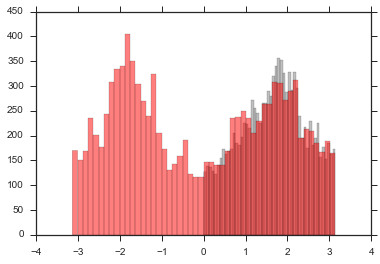

In [72]:
plt.hist(gamma[~np.isnan(gamma)],bins = 50,color = 'grey',alpha = 0.5);
plt.hist(gammaFull[~np.isnan(gammaFull)],bins = 50,color = 'red',alpha = 0.5);

##### Effect of sharp turns

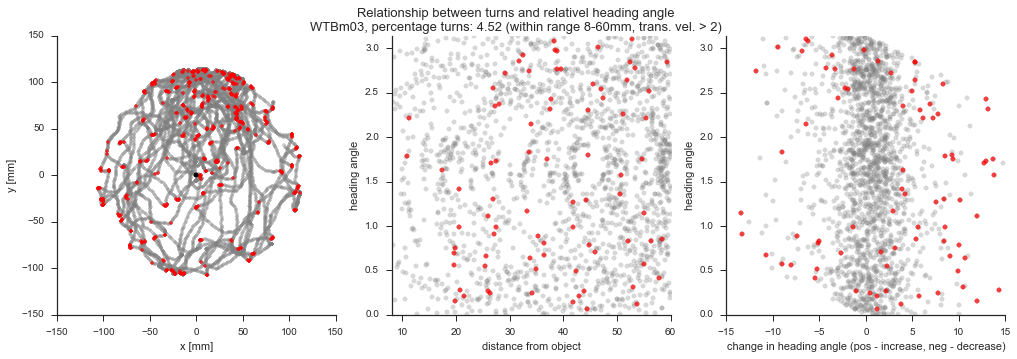

In [73]:
distRange = (near, far)
angleRange = (0, np.pi)
vHeadRange = (-15, 15)
headTurnFig = plt.figure(figsize=(17, 5))

headTurnFig.suptitle('Relationship between turns and relativel heading angle\n' + flyID + 
                     ', percentage turns: ' + str(round(100.0*sum(turnMask)/len(rotVFilt), 2)) +
                     ' (within range ' + str(near) + '-' + str(far) + 'mm, trans. vel. > ' + str(vTransTH) + ')\n',
                     fontsize=13)

ax0 = headTurnFig.add_subplot(131)
ax0.plot(xPos-objectLoc[0], yPos-objectLoc[1], '.', color='grey', alpha=0.4)
ax0.plot(xPos[turnMask]-objectLoc[0], yPos[turnMask]-objectLoc[1], '.', color='red', alpha=0.7)
ax0.plot(0, 0, marker='o', markersize=5, linestyle='none', alpha=1, color='black')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
ax0.set_aspect('equal')
myAxisTheme(ax0)

ax1 = headTurnFig.add_subplot(132)
niceScatterPlot(ax1, objDistance[selectedRangeDist], gamma[selectedRangeDist], distRange, angleRange, 'grey', 0.3)
niceScatterPlot(ax1, objDistance[selectedRangeDistTurn], gamma[selectedRangeDistTurn], distRange, angleRange,
                'red', 0.7)
plt.xlabel('distance from object')
plt.ylabel('heading angle')

ax2 = headTurnFig.add_subplot(133)
niceScatterPlot(ax2, gammaV[selectedRangeDist], gamma[selectedRangeDist], vHeadRange, angleRange, 'grey', 0.3)
niceScatterPlot(ax2, gammaV[selectedRangeDistTurn], gamma[selectedRangeDistTurn], vHeadRange, angleRange,
                'red', 0.7)
plt.xlabel('change in heading angle (pos - increase, neg - decrease)')
plt.ylabel('heading angle')
headTurnFig.savefig(baseDir + flyID + '_' + arena + '_headingVsTurning.pdf', format = 'pdf')

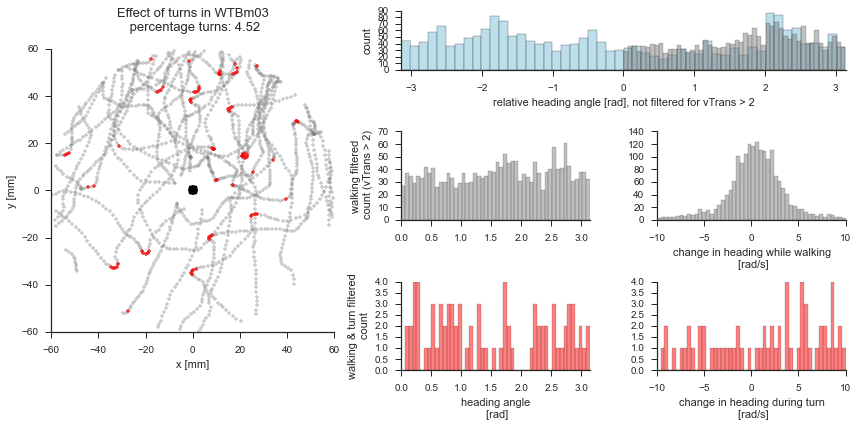

In [74]:
turnEffectFig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(3, 3, height_ratios=np.hstack((1, 1.5, 1.5)), width_ratios=np.hstack((1.5, 1, 1)))

ax0 = turnEffectFig.add_subplot(gs[:, 0])
ax0.plot(xPos[selectedRangeDist]-objectLoc[0], yPos[selectedRangeDist]-objectLoc[1], '.', color='grey', alpha=0.4)
ax0.plot(xPos[selectedRangeDistTurn]-objectLoc[0], yPos[selectedRangeDistTurn]-objectLoc[1], '.', color='red', alpha=0.7)
ax0.plot(0, 0, marker='o', markersize=10, linestyle='none', alpha=1, color='black')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
ax0.set_xlim((-arenaRad, arenaRad))
ax0.set_ylim((-arenaRad, arenaRad))
ax0.set_aspect('equal')
myAxisTheme(ax0)
ax0.set_title('Effect of turns in ' + flyID +
              '\n percentage turns: ' + str(round(100.0*sum(turnMask)/len(rotVFilt), 2)) + '\n', fontsize=13)

ax = turnEffectFig.add_subplot(gs[0, 1:3])
gammaFullSelect = gammaFull[selectedRangeDistAll]
gammaSelect = gamma[selectedRangeDistAll]
plt.hist(gammaFullSelect[~np.isnan(gammaFullSelect)], bins=50, color='lightblue', alpha=0.8)
plt.hist(gammaSelect[~np.isnan(gammaSelect)], bins=50, color='grey', alpha=0.5)
plt.xlabel('relative heading angle [rad], not filtered for vTrans > ' + str(vTransTH))
plt.ylabel('count')
ax.set_xlim((-np.pi, np.pi))
myAxisTheme(ax)

headingHist = plotVeloHistogram_fancy(gamma[selectedRangeDist], gs[1, 1], (0, np.pi), 'grey', 0.5)
headingHist.set_ylabel('walking filtered\n count (vTrans > ' + str(vTransTH) + ')')

headingHistTurn = plotVeloHistogram_fancy(gamma[selectedRangeDistTurn], gs[2, 1], (0, np.pi), 'red', 0.5)
headingHistTurn.set_ylabel('walking & turn filtered\n count')
headingHistTurn.set_xlabel('heading angle\n [rad]')

rotVHist = plotVeloHistogram_fancy(gammaV[selectedRangeDist], gs[1, 2], (-10, 10), 'grey', 0.5)
rotVHist.set_xlabel('change in heading while walking\n [rad/s]')

rotVHistFilt = plotVeloHistogram_fancy(gammaV[selectedRangeDistTurn], gs[2, 2], (-10, 10), 'red', 0.5)
rotVHistFilt.set_xlabel('change in heading during turn\n [rad/s]')

turnEffectFig.tight_layout()
turnEffectFig.savefig(baseDir + flyID + '_' + arena + '_effectOfTurns.pdf', format = 'pdf')

### Align trajectories along turns

136


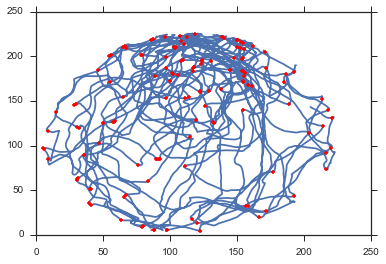

In [75]:
# find sharp turn starts
minTurnDist = 15

turnLoc = np.where(turnMask.astype('int')>0)[0]
turnStart = turnLoc[np.where(np.diff(turnLoc)>minTurnDist)[0]-N]

plt.plot(xPos,yPos)
plt.plot(xPos[turnStart],yPos[turnStart],'r.')

print(len(turnStart))

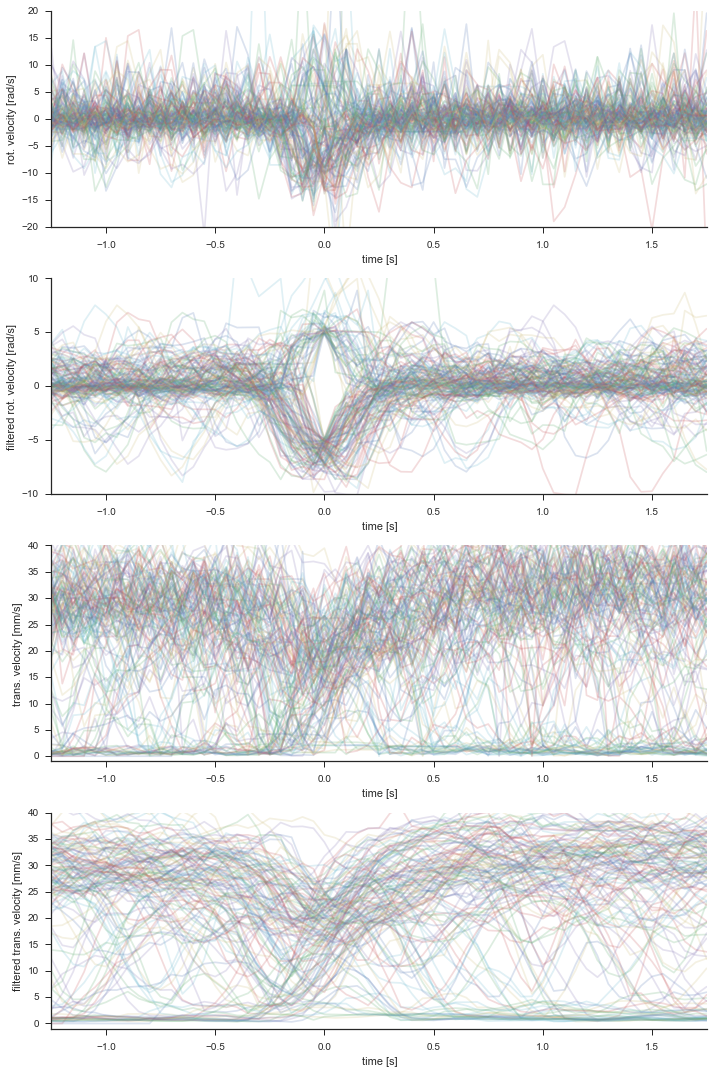

In [76]:
fig = plt.figure(figsize = (10,15))
vrot = fig.add_subplot(411)
vrotfilt = fig.add_subplot(412)
vtrans = fig.add_subplot(413)
vtransfilt = fig.add_subplot(414)

sampleRt = np.median(np.diff(timeDS))
preturn = 25
postturn = 35
timeRange = np.linspace(-preturn*sampleRt,(postturn)*sampleRt,(preturn + postturn+1))
for turn in turnStart:
    printRange = range(turn-preturn,turn+postturn+1)
    vrot.plot(timeRange,rotV[printRange],alpha = 0.2)
    vrotfilt.plot(timeRange,rotVFilt[printRange],alpha = 0.2)
    vtrans.plot(timeRange,transV[printRange],alpha = 0.2)
    vtransfilt.plot(timeRange,transVFilt[printRange],alpha = 0.2)

vrot.set_ylabel('rot. velocity [rad/s]')
vrot.set_ylim((-20,20))
vrot.set_xlim((-preturn*sampleRt,postturn*sampleRt))
vrot.set_xlabel('time [s]')
myAxisTheme(vrot)

vrotfilt.set_ylabel('filtered rot. velocity [rad/s]')
vrotfilt.set_xlim((-preturn*sampleRt,postturn*sampleRt))
vrotfilt.set_ylim((-10,10))
vrotfilt.set_xlabel('time [s]')
myAxisTheme(vrotfilt)

vtrans.set_ylabel('trans. velocity [mm/s]')
vtrans.set_ylim((-1,40))
vtrans.set_xlim((-preturn*sampleRt,postturn*sampleRt))
vtrans.set_xlabel('time [s]')
myAxisTheme(vtrans)

vtransfilt.set_ylabel('filtered trans. velocity [mm/s]')
vtransfilt.set_ylim((-1,40))
vtransfilt.set_xlim((-preturn*sampleRt,postturn*sampleRt))
vtransfilt.set_xlabel('time [s]')
myAxisTheme(vtransfilt)

plt.tight_layout()

1.0000999999999749

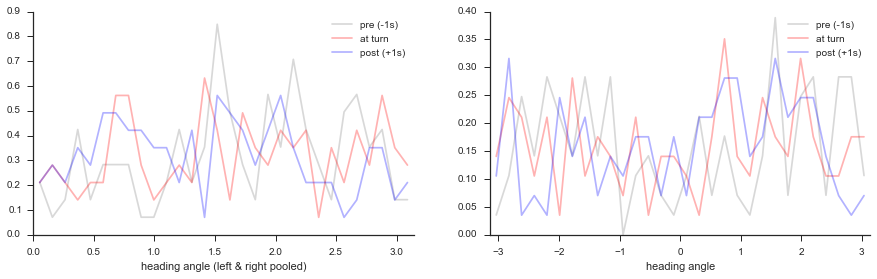

In [77]:
windowSize = 20
angleRange1 = (0,np.pi)
angleRange2 = (-np.pi,np.pi)
fig = plt.figure(figsize = (15,4))
headChange1 = fig.add_subplot(121)
n, bins = np.histogram(gamma[turnStart-windowSize], bins = 30, range=angleRange1, normed=True) #pre
plt.plot(bins[:-1]+0.5*np.mean(np.diff(bins)), n, color='grey', alpha = 0.3)
n, bins = np.histogram(gamma[turnStart], bins = 30, range=angleRange1, normed=True) #at turn
plt.plot(bins[:-1]+0.5*np.mean(np.diff(bins)), n, color='red', alpha = 0.3)
n, bins = np.histogram(gamma[turnStart+windowSize], bins = 30, range=angleRange1, normed=True) #post
plt.plot(bins[:-1]+0.5*np.mean(np.diff(bins)), n, color='blue',alpha = 0.3)
plt.xlim(0,np.pi);
headChange1.set_xlabel('heading angle (left & right pooled)')
plt.legend(['pre (-1s)','at turn','post (+1s)'])
myAxisTheme(headChange1)

headChange2 = fig.add_subplot(122)
n, bins = np.histogram(gammaFull[turnStart-windowSize], bins = 30, range=angleRange2, normed=True) #pre
plt.plot(bins[:-1]+0.5*np.mean(np.diff(bins)), n, color='grey', alpha = 0.3)
n, bins = np.histogram(gammaFull[turnStart], bins = 30, range=angleRange2, normed=True)     #at turn
plt.plot(bins[:-1]+0.5*np.mean(np.diff(bins)), n, color='red', alpha = 0.3)
n, bins = np.histogram(gammaFull[turnStart+windowSize], bins = 30, range=angleRange2, normed=True) #post
plt.plot(bins[:-1]+0.5*np.mean(np.diff(bins)), n, color='blue',alpha = 0.3)
plt.xlim(-np.pi,np.pi);
headChange2.set_xlabel('heading angle')
plt.legend(['pre (-1s)','at turn','post (+1s)'])
myAxisTheme(headChange2)

windowSize*sampleRt

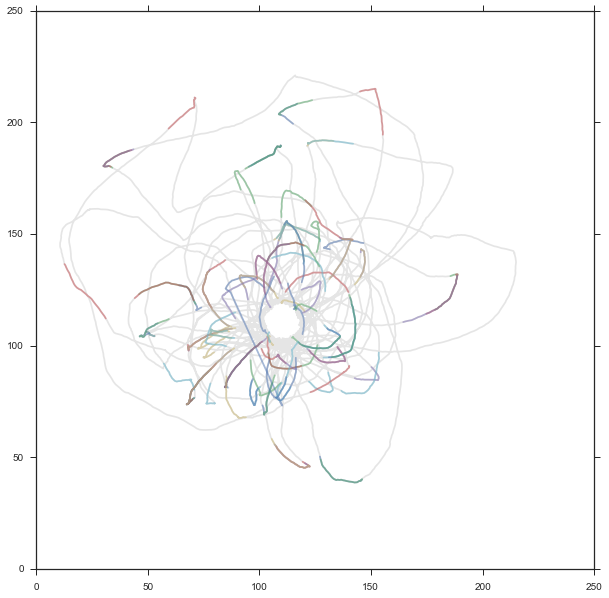

In [36]:
sampleRt = np.median(np.diff(timeDS))
preturn = 10
postturn = 20
timeRange = np.linspace(-preturn*sampleRt,(postturn)*sampleRt,(preturn + postturn+1))

fig = plt.figure(figsize = (10,10))
plt.plot(xPos,yPos,color = 'grey',alpha = 0.2)

for turn in turnStart:
    printRange = range(turn-preturn,turn+postturn+1)
    plt.plot(xPos[printRange],yPos[printRange],alpha = 0.5)
    

(-115, 0)

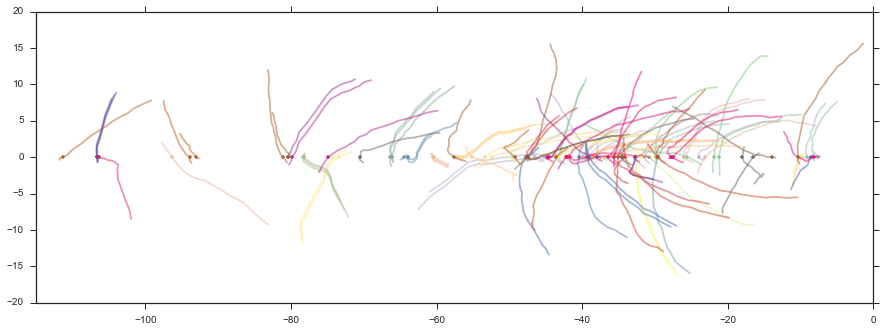

In [37]:
sampleRt = np.median(np.diff(timeDS))
preturn = 2
postturn = 15
timeRange = np.linspace(-preturn*sampleRt,(postturn)*sampleRt,(preturn + postturn+1))

cNorm  = colors.Normalize(vmin=0, vmax=len(turnStart))
scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

fig = plt.figure(figsize = (15,7))
#preAl = fig.add_subplot(1,2,1)
#postAl = fig.add_subplot(1,2,2)
postAl = fig.add_subplot(1,1,1)

for ind,turn in enumerate(turnStart):
    currCol=scalarMap.to_rgba(ind)

    printRange = range(turn-preturn,turn+postturn+1)
    
    rotMatrix = np.array([[np.cos(2*np.pi-phi[turn]), -np.sin(2*np.pi-phi[turn])], 
                             [np.sin(2*np.pi-phi[turn]),  np.cos(2*np.pi-phi[turn])]])
    
    turnTraj = np.vstack((xPos[printRange]-objectLoc[0],yPos[printRange]-objectLoc[1]))
    turnTrajSt = np.vstack((xPos[turn]-objectLoc[0],yPos[turn]-objectLoc[1]))

    aligned_turnTraj = np.dot(rotMatrix, turnTraj)
    aligned_turnTrajSt = np.dot(rotMatrix, turnTrajSt)
    
    #preAl.plot(turnTraj[0,:],turnTraj[1,:],alpha = 0.5)
    postAl.plot(aligned_turnTraj[0,:],aligned_turnTraj[1,:],color = currCol, alpha = 0.5)
    postAl.plot(aligned_turnTrajSt[0,:],aligned_turnTrajSt[1,:],color = currCol, marker = '.',alpha = 0.9)

#preAl.set_aspect('equal')
postAl.set_aspect('equal')
postAl.set_ylim(-20,20)
postAl.set_xlim(-115,0)

### "Directional modulation of runs"    -   Gomez-Marin and Louis, 2014

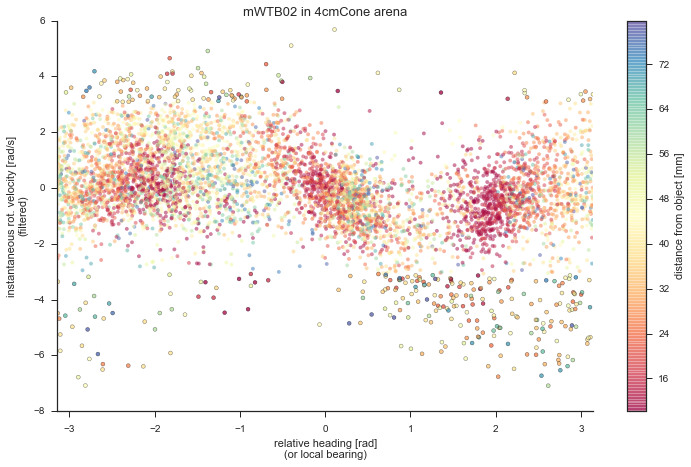

In [38]:
near = 10
far = 80

selectedRangeDist = np.logical_and(np.logical_and(objDist>near,objDist<far),transV>5)
selectedRangeDistTurn = np.logical_and(selectedRangeDist,turnMask)


turnModfig = plt.figure(figsize = (12,7))
turnMod = turnModfig.add_subplot(1,1,1)
turnModsc = plt.scatter(gammaFull[selectedRangeDist],rotVFilt[selectedRangeDist],
                        marker='o', s=15, linewidths=0,
                        c=objDist[selectedRangeDist], cmap=plt.cm.Spectral, alpha = 0.5)
turnModsc = plt.scatter(gammaFull[selectedRangeDistTurn],rotVFilt[selectedRangeDistTurn],
                        marker='o', s=15, linewidths=0.5,
                        c=objDist[selectedRangeDistTurn], cmap=plt.cm.Spectral, alpha = 0.5)
turnMod.set_xlim(-np.pi,np.pi)
turnMod.set_ylim(-8,6)
turnMod.set_xlabel('relative heading [rad]\n(or local bearing)')
turnMod.set_ylabel('instantaneous rot. velocity [rad/s]\n(filtered)');

turnModcb = plt.colorbar(turnModsc)
turnModcb.set_label('distance from object [mm]')
myAxisTheme(turnMod)

turnMod.set_title(flyID + ' in ' + arena + ' arena (within range ' + str(near) + '-' + str(far) + 'mm)', fontsize = 13)

turnModfig.savefig('/Users/hannah/Desktop/sharpTurnAnalysis/' + flyID + '_' + arena + '_turnMod_all.pdf', format = 'pdf')

(0, 10)

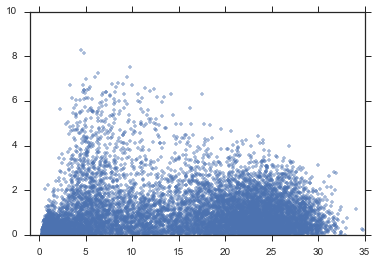

In [62]:
plt.plot(transVFilt,abs(rotVFilt),'.', alpha = 0.5)
#plt.plot(transVFilt[turnMask],abs(rotVFilt[turnMask]),'r.', alpha = 0.1)
plt.xlim(-1,35)
plt.ylim(0,10)

(0, 3.141592653589793)

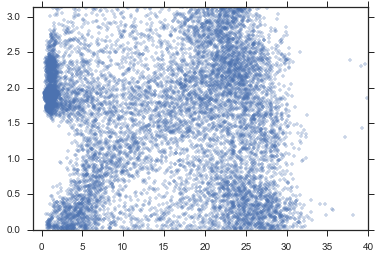

In [72]:
plt.plot(transVFilt,gamma,'.', alpha = 0.3)
plt.xlim(-1,40)
plt.ylim(-0,np.pi)

In [1]:
# Turn index...


### Random scraps

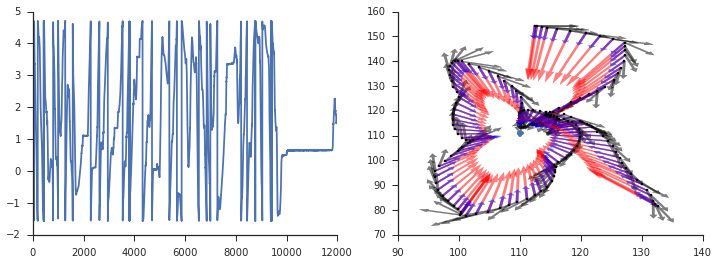

In [935]:
objectOriFig = plt.figure(figsize = (12,4))

oriangleTrace = plt.subplot(1,2,1)
oriangleTrace.plot(oriangle)
myAxisTheme(oriangleTrace)

oriAx = plt.subplot(1,2,2)
for f in range(200,500,2):
    oriAx.plot(xPos[f],yPos[f],marker = '.',markersize = 5, color = 'black')
    plotBodyAngle(oriAx,xPos[f],yPos[f],angle[f],'black',0.5,7)
    
    plotBodyVector(oriAx,xPos[f],yPos[f],objectDirection[:,f],'red',0.5,0.5)
    
    plotBodyAngle(oriAx,xPos[f],yPos[f],oriangle[f],'blue',0.5,5)

oriAx.plot(objectLoc[0],objectLoc[1],marker = 'o')
myAxisTheme(oriAx)

### Headedness

In [469]:
arenaCenter = np.asarray((240*pixel2mm, 240*pixel2mm))
flyPos = np.vstack((xPos,yPos))
dCenter =  flyPos.T - np.tile(arenaCenter,[len(xPos),1]) #vector from fly to arena center

#angular position from arena center: 0 to pi on upper half...
angPos =  np.arccos(dCenter[:,0] / np.sqrt(np.square(dCenter[:,0]) + np.square(dCenter[:,1])) )
angPos[dCenter[:,1] < 0] = 2*np.pi - angPos[dCenter[:,1] < 0];

In [470]:
orientationScore = abs(angPos - angle)

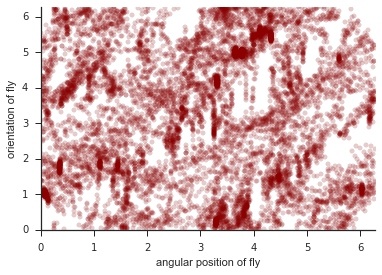

In [498]:
fig = plt.figure()
headax = fig.add_subplot(1,1,1)
plt.scatter(angPos,angle, alpha = 0.2,color = 'darkred')
plt.xlabel('angular position of fly')
plt.ylabel('orientation of fly')
headax.set_ylim(0,2*np.pi)
headax.set_xlim(0,2*np.pi)
myAxisTheme(headax)

In [484]:
heading = np.arctan(np.diff(yPos)/np.diff(xPos))
heading = np.hstack((heading[1],heading))
circlingScore = abs(angPos - heading+np.pi)

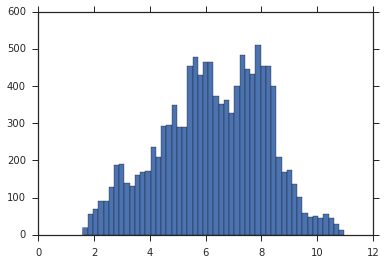

In [495]:
selected_values = ~np.isnan(circlingScore)
plt.hist(circlingScore[selected_values],bins = 50);